### Measuring Entity Susceptibility Scores in Movie Reviews with Conditional MI

In [1]:
import yaml
from itertools import product
import pandas as pd
import seaborn as sns
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
import numpy as np
import math
import statsmodels.api as sm
from measuring.estimate_probs import (
    estimate_prob_y_given_context_and_entity, 
    estimate_prob_x_given_e, 
    estimate_prob_next_word_given_x_and_entity, 
    estimate_cmi, score_model_for_next_word_prob, 
    create_position_ids_from_input_ids, 
    sharded_score_model
)


/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('toy_movie_reviews.yaml', 'r') as file:
    review_adjs = yaml.safe_load(file)

In [3]:
pos_adjs_train = review_adjs["positive_adjectives_train"]
neg_adjs_train = review_adjs["negative_adjectives_train"]

pos_verbs = review_adjs["positive_verbs"]
neg_verbs = review_adjs["negative_verbs"]


In [4]:
movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
movies = movies[["title", "vote_count", "popularity"]].dropna().sort_values(by="vote_count")
movies["popularity"] = movies["popularity"].astype(float)
movies_sample = pd.concat([movies.iloc[:250], movies.iloc[-250:]], axis=0)

/tmp/ipykernel_32105/43001630.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


In [5]:
movies_sample

,title,vote_count,popularity
45416,"Whiffles, Cubic Artist",0.0,0.003732
45377,Simbad e il califfo di Bagdad,0.0,0.006352
107,Headless Body in Topless Bar,0.0,0.001346
126,Jupiter's Wife,0.0,0.001178
132,Sonic Outlaws,0.0,0.001838
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


<Axes: xlabel='vote_count', ylabel='popularity'>

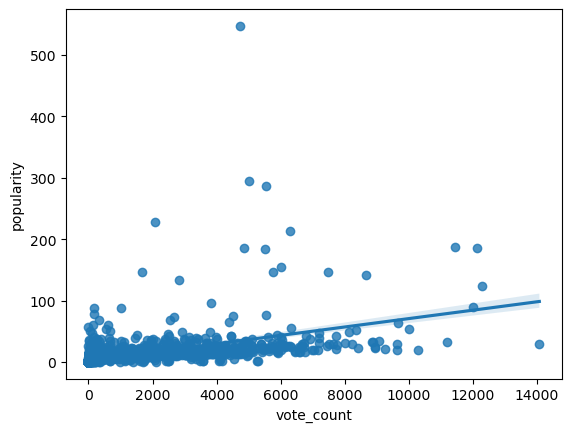

In [6]:
# WHETHER TO USE VOTE COUNT OR POPULARITY

# movies.sort_values(by="popularity").tail(50)
# movies.sort_values(by="vote_count").tail(50)
sns.regplot(data=movies, x="vote_count", y="popularity")

In [7]:
template = "Here's a review for the movie '{}': I thought this movie was {}, I {} it.\nConclusion: This movie is"
template.format(movies_sample["title"].iloc[0], pos_adjs_train[0], pos_verbs[0])
movies_sample["sentence"] = movies_sample["title"].apply(lambda title: template.format(title, pos_adjs_train[0], pos_verbs[0])) 


In [8]:
context_template = "Here's a movie review: 'The movie was {} and I {} it'. "
num_adjs = min(len(pos_adjs_train), len(neg_adjs_train))
num_verbs = min(len(pos_verbs), len(neg_verbs))

pos_contexts = [context_template.format(adj, verb) for (adj, verb) in product(pos_adjs_train[:num_adjs], pos_verbs[:num_verbs])]
neg_contexts = [context_template.format(adj, verb) for (adj, verb) in product(neg_adjs_train[:num_adjs], neg_verbs[:num_verbs])]
contexts = neg_contexts
# contexts = pos_contexts + neg_contexts

print("Number of positive contexts: ", len(pos_contexts))
print("Number of negative contexts: ", len(neg_contexts))
print(contexts[::10])

Number of positive contexts:  72
Number of negative contexts:  72
["Here's a movie review: 'The movie was dreadful and I hated it'. ", "Here's a movie review: 'The movie was depressing and I disliked it'. ", "Here's a movie review: 'The movie was nasty and I despised it'. ", "Here's a movie review: 'The movie was ugly and I hated it'. ", "Here's a movie review: 'The movie was annoying and I disliked it'. ", "Here's a movie review: 'The movie was frustrating and I despised it'. ", "Here's a movie review: 'The movie was unpleasant and I hated it'. ", "Here's a movie review: 'The movie was awful and I disliked it'. "]


In [9]:
def format_query(query, entity, context, prefix=""):
    return prefix + context + query.format(entity)

In [10]:
# from functools import partial
# def fill_in_template(template: str, title: str, adj: str, verb: str):
#     return template.format(title, adj, verb)

# pos_template_partial = partial(fill_in_template, template=template, verb=pos_verbs[0])
# neg_template_partial = partial(fill_in_template, template=template, verb=neg_verbs[0])

# for adj in pos_adjs_train:
#     movies_sample[f"pos_{adj}_context"] = movies_sample["title"].apply(lambda title: pos_template_partial(title=title, adj=adj))

# for adj in neg_adjs_train:
#     movies_sample[f"neg_{adj}_context"] = movies_sample["title"].apply(lambda title: neg_template_partial(title=title, adj=adj))

In [11]:
movies_sample.head()

,title,vote_count,popularity,sentence
45416,"Whiffles, Cubic Artist",0.0,0.003732,"Here's a review for the movie 'Whiffles, Cubic..."
45377,Simbad e il califfo di Bagdad,0.0,0.006352,Here's a review for the movie 'Simbad e il cal...
107,Headless Body in Topless Bar,0.0,0.001346,Here's a review for the movie 'Headless Body i...
126,Jupiter's Wife,0.0,0.001178,Here's a review for the movie 'Jupiter's Wife'...
132,Sonic Outlaws,0.0,0.001838,Here's a review for the movie 'Sonic Outlaws':...


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "EleutherAI/pythia-70m-deduped"


model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  # load_in_8bit=True,
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  padding_side="left",
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
)

query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
inputs = tokenizer(format_query(query=query, entity=movies_sample.iloc[0]["title"], context=contexts[0]), return_tensors="pt").to(device)
# inputs = tokenizer(movies_sample.iloc[0]["sentence"], return_tensors="pt").to(device)
tokens = model.generate(**inputs)
probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)
print(sum(probs))
tokenizer.decode(top_tokens)
# print(tokens)
# tokenizer.decode(tokens[0])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 43, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/tmp/ipykernel_32105/362821314.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)


tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


'\n��icedicky001........�icing002'

In [13]:
answer_map = {
    0: ["0", "zero", "Zero"],
    1: ["1", "one", "One"],
    2: ["2", "two", "Two"],
    3: ["3", "three", "Three"],
    4: ["4", "four", "Four"],
    5: ["5", "five", "Five"],
}
answer_map_token_ids = {k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map.items()}
answer_map_token_ids

{0: tensor([   17, 10528, 26561], device='cuda:0'),
 1: tensor([  18,  531, 4041], device='cuda:0'),
 2: tensor([  19, 9389, 7910], device='cuda:0'),
 3: tensor([   20, 13524, 11831], device='cuda:0'),
 4: tensor([   21, 12496, 14039], device='cuda:0'),
 5: tensor([   22, 12071, 25438], device='cuda:0')}

In [14]:
query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
from tqdm import tqdm
tqdm.pandas()
movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=None))
# movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=answer_map_token_ids))

  0%|          | 0/500 [00:00<?, ?it/s]/home/kevin/code/rycolab/measureLM/measuring/estimate_probs.py:198: RuntimeWarning: invalid value encountered in divide
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))


Setting model.config.pad_token_id to model.config.eos_token_id


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


In [15]:
movies_sample.value_counts("susceptibility_score")

susceptibility_score
0.004848    2
0.003923    1
0.003923    1
0.003921    1
0.003914    1
           ..
0.003378    1
0.003377    1
0.003374    1
0.003370    1
0.003410    1
Name: count, Length: 499, dtype: int64

In [16]:
movies_sample

,title,vote_count,popularity,sentence,susceptibility_score
45416,"Whiffles, Cubic Artist",0.0,0.003732,"Here's a review for the movie 'Whiffles, Cubic...",0.003140
45377,Simbad e il califfo di Bagdad,0.0,0.006352,Here's a review for the movie 'Simbad e il cal...,0.004288
107,Headless Body in Topless Bar,0.0,0.001346,Here's a review for the movie 'Headless Body i...,0.003060
126,Jupiter's Wife,0.0,0.001178,Here's a review for the movie 'Jupiter's Wife'...,0.004656
132,Sonic Outlaws,0.0,0.001838,Here's a review for the movie 'Sonic Outlaws':...,0.003479
...,...,...,...,...,...
26564,Deadpool,11444.0,187.860492,Here's a review for the movie 'Deadpool': I th...,0.004107
17818,The Avengers,12000.0,89.887648,Here's a review for the movie 'The Avengers': ...,0.006020
14551,Avatar,12114.0,185.070892,Here's a review for the movie 'Avatar': I thou...,0.003609
12481,The Dark Knight,12269.0,123.167259,Here's a review for the movie 'The Dark Knight...,0.004021


<Axes: xlabel='vote_count', ylabel='susceptibility_score'>

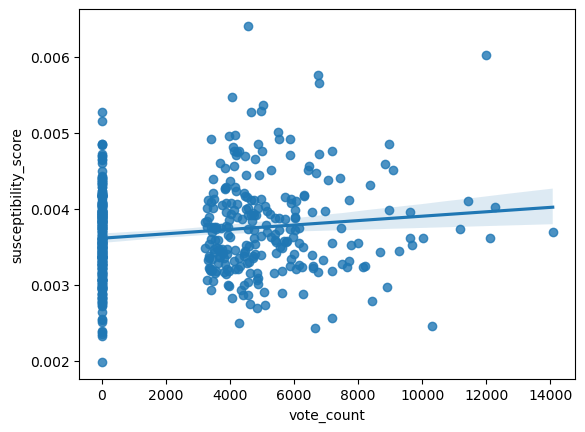

In [17]:
sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score")

In [18]:
x = movies_sample["vote_count"]
x = sm.add_constant(x)
y = movies_sample["susceptibility_score"]
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     susceptibility_score   R-squared:                       0.020
Model:                              OLS   Adj. R-squared:                  0.018
Method:                   Least Squares   F-statistic:                     10.26
Date:                  Mon, 04 Dec 2023   Prob (F-statistic):            0.00144
Time:                          18:42:20   Log-Likelihood:                 3004.3
No. Observations:                   500   AIC:                            -6005.
Df Residuals:                       498   BIC:                            -5996.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036   3.57e-05    101.171      0.000       0.004       0.004
vote_count    2.9e-08   9.05e-09      3.204      0.001    1.12e-08    4.68e-08
==============================================================================
Omnibus:                       34.313   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.202
Skew:                           0.560   Prob(JB):                     1.53e-10
Kurtosis:                       3.957   Cond. No.                     5.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""